In [47]:
import networkx as nx
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
import keras
import numpy as np
import matplotlib
import re
from sklearn import metrics

%matplotlib inline

Generate a very simple classification task:

X with 3 features following a uniform dist.
Y labels for values greater .7 for each feature

In [10]:
numTrainSamples = 10000
numTestSamples = 3000
numFeatures = 3
thresh = .5
X_train = np.random.rand(numTrainSamples,numFeatures)
Y_train = np.all(X_train>thresh,axis=1)

X_test = np.random.rand(numTestSamples,numFeatures)
Y_test = np.all(X_test>thresh,axis=1)

Y_train = np_utils.to_categorical(Y_train)

Set up the Network

In [114]:
input_num = X_train.shape[1]
output_num = Y_train.shape[1]
layers = [input_num,100,100,output_num]
layerNames = ['input','L1','L2','output']

model = Sequential()
for ix,i in enumerate(layers):
    if(ix <len(layers)-1):
        model.add(Dense(i,layers[ix+1]))#,weights=[np.random.randint(2,size=(i,layers[ix+1]))]))
        model.add(Activation('sigmoid'))

model.compile(loss='mse',optimizer='rmsprop')

Display the model as a Network

In [115]:
originalGraph = kerasToGraph(model,layerNames)

In [75]:
for x in originalGraph.nodes():
    print(x)

input_1
L1_0
L1_2
L1_1
output_0
input_0
output_1
input_2


In [76]:
get_connected_nodes(originalGraph,'L1_1')

[('input_1', 'L1_1'), ('input_0', 'L1_1'), ('input_2', 'L1_1')]

In [61]:
graph_to_keras(originalGraph,layerNames,weightInitialization = 'uniform')

{'output_0': 'mse', 'output_1': 'mse'}


AttributeError: 'float' object has no attribute 'name'

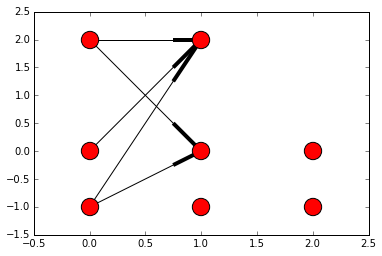

In [18]:
plotForwardNeuralNet(originalGraph,layerNames,weighted=True)

##Questions:
Annealing v. Fixing? How to isolate impact? and follow up: <br /> 
\How to get uniform on all parameters but one to isolate impact in graph initialization? <br /> 


Train the model

In [204]:
model.fit(X_train, Y_train, nb_epoch=1000, batch_size=9000, validation_split=0.1, show_accuracy=True,verbose=0)

In [205]:
preds = model.predict_classes(X_test)
metrics.confusion_matrix(Y_test,preds)

3000/3000 [==============================] - 0s     


array([[2638,    0],
       [ 362,    0]])

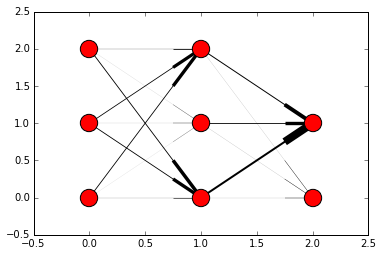

In [206]:
trainedGraph = kerasToGraph(model,layerNames)
plotForwardNeuralNet(trainedGraph,layerNames,weighted=True)

In [220]:
nx.pagerank(trainedGraph)

{'L1_0': 0.14729179694992722,
 'L1_1': 0.053847832389729386,
 'L1_2': 0.16237670107178254,
 'input_0': 0.065498609500934266,
 'input_1': 0.065498609500934266,
 'input_2': 0.065498609500934266,
 'output_0': 0.39828775219440349,
 'output_1': 0.041700088891354584}

## Util Functions

In [14]:
def graphAddLayer(graph, fromLayer,toLayer,connectionMatrix,threshhold=0,sep='_'):
    '''
    This method grows a graph according to non-zero connection matrix for to layers in a neural net
    This method takes as inputs:
    -a NetworkX object, graph
    -the name of the fromLayer and toLayer
    -a connection matrix of dimension fromLayer x toLayer
    and returns:
    -the grown graph
    '''
    fromNodeNames = list(map(lambda x: str(fromLayer) + sep + str(x),range(connectionMatrix.shape[0]))) #generate the names for the fromLayer
    toNodeNames = list(map(lambda x: str(toLayer) + sep + str(x),range(connectionMatrix.shape[1]))) #generate the names for the toLayer
    
    #add the nodes to the graph
    graph.add_nodes_from(fromNodeNames + toNodeNames)
    
    booleanMatrix = np.abs(connectionMatrix) > threshhold 
    
    #generate the edges
    edges = []
    for fromIX,fromNode in enumerate(fromNodeNames):
        for toIX,toNode in enumerate(toNodeNames):
            if(booleanMatrix[fromIX][toIX]):
                edges.append((fromNode,toNode, connectionMatrix[fromIX][toIX]))
    graph.add_weighted_edges_from(edges)
    
    return graph

In [13]:
def plotForwardNeuralNet(graph,layerNames,weighted=False, scaling= lambda x:x):
    '''
    This function returns a matplotlib object of a bipartite neural net
    It takes as input:
    -a NetworkX Graph
    -a list of layer names (could be deprecated with a regex but w/e)
    '''
    
    ##TODO: Make it return the Matplotlib object or figure isntead of automatically drawing
    
    listOfLayers = separateLayers(graph.nodes(),layerNames)
    positions = dict()
    for ix,layer in enumerate(listOfLayers):
        positions.update((n, (ix, i*(1-2*(i%2)))) for i, n in enumerate(layer))
    if weighted:
        nx.draw_networkx_nodes(graph,pos=positions) #draw the nodes
        #Loop through each edge 
        for (fromNode,toNode,weight) in graph.edges(data=True):
            nx.draw_networkx_edges(graph,positions,edgelist=[(fromNode,toNode)],width=scaling(weight['weight']))
    else:
        nx.draw(graph, pos=positions)

In [12]:
def kerasToGraph(model,layerNames,threshhold=0): #can change to list of threshholds or some methods or something
    '''
    This function converts a keras neural network to a NetworkX graph
    Inputs:
    -model, the keras model
    -layerNames, the list of layer names
    -threshhold(optional) - the absolute value above which the edge should be drawn
    '''
    graph = nx.DiGraph() #Use directed graph for now
    for ix,layerName in enumerate(layerNames):
        if ix >0:
            graph = graphAddLayer(graph,layerNames[ix-1],layerNames[ix],model.get_weights()[(ix-1)*2],threshhold)
    return(graph)
    

In [17]:
def separateLayers(listOfNodes,layerNames,sep='_'):
    """
    This function identifies the layers of a neural network based on the names of the layers
    Inputs:
    -a list of strings corresponding to nodes in a graph
    -a list of layer names
    Returns:
    -a list of lists with the names of nodes of each layer in a separate list
    """
    layers =[]
    for layer in layerNames:
        temp = []
        for node in listOfNodes:
            if re.search(layer+sep,node):
                temp.append(node)
        layers.append(temp)
    return layers

In [108]:
def graph_to_keras(graph,layerNames,weightInitialization = 'uniform',weights=None,activationFunction='sigmoid',nDim = 2):
    '''
    This function builds a neural network from a sequential bipartite graph with defined edges
    inputs:
        - graph : a NetworkX graph in the order L1..-Ln-output, each specifying the connection of the previous layer to that layer, ie) there are Layers-1 graphs
        - layer_names : a list of names to assign to each layer, the nodes will have the subscript _X
        - weight_initialization : the function to initialize the weights, default uniform
        - weights : a predefined list of weights with each index corresponding to the layer connections, overloads weight_initialization
        - activation_function : the activation function from keras to be incorporated for all layers, TODO: make it variable ased on each layer

    output:
        - keras model
    '''
    
    #begin constructing the model
    model = keras.models.Graph()
    #add the input, get the number of I/O from the graphs
    inputNodes = get_nodes_with_string(graph,layerNames[0])
    for inputNode in inputNodes: #if it's input, make it input
        model.add_input(name=inputNode, ndim=2)
    for ix,layerName in enumerate(layerNames[1:]):
        nodes=get_nodes_with_string(graph,layerName)
        for ix,node in enumerate(nodes):
            connectedNodes = get_connected_nodes(originalGraph,node)
            if layerName == layerNames[-1]: # if it's output, make it output
                if  len(connectedNodes) == 0:
                    continue
                if len(connectedNodes) == 1:
                    model.add_output(name=node,input= connectedNodes[0][0])
                else:
                    model.add_output(name=node,inputs=[i[0] for i in connectedNodes])
            else: #other wise, pairwise connect it with the last layer, super slow i imagine
                if  len(connectedNodes) == 0:
                        continue
                if len(connectedNodes) == 1:
                    model.add_node(keras.layers.core.Dense(1,1,activation=activationFunction),name=node,input= connectedNodes[0][0])
                else:
                    model.add_node(keras.layers.core.Dense(1,1,activation=activationFunction),inputs=[i[0] for i in connectedNodes],name=node)
    #Build output dict
    outputDict = {node : 'mse' for node in nodes}
    model.compile('rmsprop', outputDict)
    return(model)
    

In [ ]:
graph_to_keras(originalGraph,layerNames)

['L1_68', 'L1_23', 'L1_52', 'L1_77', 'L1_30', 'L1_79', 'L1_45', 'L1_19', 'L1_67', 'L1_44', 'L1_86', 'L1_72', 'L1_69', 'L1_37', 'L1_39', 'L1_49', 'L1_90', 'L1_64', 'L1_9', 'L1_73', 'L1_12', 'L1_76', 'L1_15', 'L1_21', 'L1_14', 'L1_57', 'L1_63', 'L1_41', 'L1_16', 'L1_27', 'L1_98', 'L1_7', 'L1_26', 'L1_82', 'L1_74', 'L1_31', 'L1_40', 'L1_35', 'L1_18', 'L1_95', 'L1_89', 'L1_53', 'L1_96', 'L1_5', 'L1_2', 'L1_60', 'L1_42', 'L1_75', 'L1_32', 'L1_11', 'L1_55', 'L1_83', 'L1_38', 'L1_99', 'L1_66', 'L1_1', 'L1_13', 'L1_61', 'L1_62', 'L1_94', 'L1_81', 'L1_56', 'L1_25', 'L1_46', 'L1_0', 'L1_33', 'L1_93', 'L1_78', 'L1_65', 'L1_8', 'L1_3', 'L1_58', 'L1_20', 'L1_43', 'L1_4', 'L1_6', 'L1_29', 'L1_51', 'L1_80', 'L1_34', 'L1_85', 'L1_92', 'L1_50', 'L1_88', 'L1_71', 'L1_17', 'L1_24', 'L1_97', 'L1_91', 'L1_36', 'L1_47', 'L1_87', 'L1_59', 'L1_10', 'L1_70', 'L1_22', 'L1_28', 'L1_48', 'L1_84', 'L1_54']
['L2_36', 'L2_92', 'L2_40', 'L2_19', 'L2_96', 'L2_94', 'L2_4', 'L2_95', 'L2_72', 'L2_2', 'L2_87', 'L2_55', 'L

In [42]:
def get_nodes_with_string(graph,string):
    myRegex = re.compile(r''+string+'_[0-9]+')
    return(myRegex.findall(' '.join(graph.nodes())))
def get_connected_nodes(graph,node,inEdges=True,outEdges=False):
    edges = []
    for edge in graph.edges_iter():
        if inEdges:
            if edge[1] == node:
                edges.append(edge)
                continue
        if outEdges:
            if edge[0] == node:
                edges.append(edge)
    return(edges)

In [55]:
layerNames[-1]

'output'

In [10]:
layernames = ['input'] + ['L'+str(x) for x in range(layer_sizes-2)] + ['output']

In [28]:
a = ['%s to %s' % t for t in zip(layerNames[:-1], layerNames[1:])]